# Drift Monitoring with the Howso Engine

## Overview

This recipe will demonstrate Howso Engine’s ability to handle and monitor model drift. Howso Engine can be used to monitor any potential drift by evaluating bias in both new and ongoing models using online learning and interpretability. By using the Engine's interpretability, users can pair the Howso Engine alongside their deployed deep-learning models to get early indicators to detect and investigate drift.

Drift can occur in various forms, such as: 
1. Concept drift
    - changes in the relationship between features and the target variable
    - example: user preferences evolve with time
2. Data drift (Covariate shift)
    * a. Label drift
        - When the output data drifts
        - example: when the ratio of real positive diagnosis is much higher in the test data than in the training data
        - commonly an issue with Bayesian techniques
    * b. Feature drift
        - changes in data structure, for example there is a new target variable or new distribution of data
        - example: new customer segment. If an existing model is trained on teens under 18 years of age, then test age introduces a population over 18, the model might not be adequate for this new population.

This recipe will focus on data drifts, and more specifically, feature drifts.

In [1]:
import os

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from pmlb import fetch_data

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes
from howso.visuals import plot_anomalies

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

In [2]:
# Helper function graph blobs
def graph_blobs(dataframe: pd.DataFrame):
    color_map = {
        'peach': 'orange',
        'kiwi': 'green',
        'apple': 'red',
        'mango': 'blue'
    }

    fig = px.scatter_3d(
        dataframe,
        x='weight',
        y='size',
        z='sweetness',
        color='target',
        color_discrete_map=color_map,
    )

    # Update traces to adjust marker size and other properties
    fig.update_traces(marker=dict(size=5, opacity=0.8))

    pio.show(fig)

# Prep. Base dataset

Our base dataset consists of 4 features including a target feature of `fruit` with 4 different values: 

1. apple
2. peach
3. mango
4. kiwi

These fruits each form a distinct cluster. `apple`, `peach`, and `mango` each contain about 20% noise, which are just mislabeled cases. `kiwi` is labeled 100% correctly. These fruits have the features `weight`, `size`, and `sweetness` (on a numerical increasing scale).

**NOTE:** These values are artificial and are only mildly representative of the real values. They are for demonstrative purposes only.

The `apple`, `peach`, and `mango` clusters only differ on `sweetness`, indicating that they are generally similar sizes, thus they essentially form a line of clusters. `kiwi` differs on `size`, forming a cluster that does not follow the same line as the other clusters.

A visualization of the dataset is below:


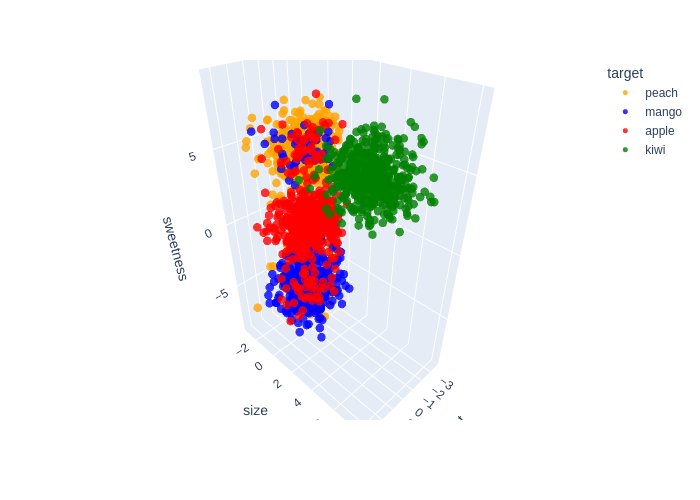

In [3]:
# Define the centers of the clusters
centers = [
    [0, 0, 0],  # Cluster 1, apple
    [0, 0, 5],  # Cluster 2, peach
    [0, 0, -5], # Cluster 3, mango
    [0, 5, 5]   # Cluster 4, kiwi, feature size shifted
]

X, y = make_blobs(n_samples=2000, n_features=3, centers=centers, cluster_std=1.0)
df = pd.DataFrame(X, columns=['weight', 'size', 'sweetness'])
df['target'] = y

# Define the labels for each cluster
cluster_labels = ['apple', 'peach', 'mango', 'kiwi']
df['target'] = df['target'].map(lambda x: cluster_labels[x])

# Split out the datsets between kiwi data and non-kiwi data
non_kiwi_data = df[df['target'].isin(['apple', 'peach', 'mango'])].reset_index(drop=True)
kiwi_data = df[df['target'] == 'kiwi'].reset_index(drop=True)

# Add noise to non-kiwi data by swapping fruits
swap_percentage = 0.2
num_samples = len(non_kiwi_data)
swap_indices = np.random.choice(num_samples, size=int(swap_percentage * num_samples), replace=False)
for i in swap_indices:
    current_fruit = non_kiwi_data.at[i, 'target']
    new_fruit = np.random.choice(['apple', 'peach', 'mango'])
    while new_fruit == current_fruit:
        new_fruit = np.random.choice(['apple', 'peach', 'mango'])
    non_kiwi_data.at[i, 'target'] = new_fruit

# Recombine the kiwi and non-kiwi dataset with noise back into one dataset
df = pd.concat([non_kiwi_data, kiwi_data]).reset_index(drop=True)

graph_blobs(df)

## Scenario 1: Data drift on live dummy data


**Scenario**: We we have a production model and we are making live predictions for real-time use. This means that we do not have access to the true value of the target variable for the new incoming test data.
- In this scenario, initially only the fruits `apple`, `peach`, `mango` are present, thus the training data and model is built on only the data from those fruits. Thus `kiwi`'s are not present in the training data and thus not represented by the production model.

**Drift**: Afer a while the data drifts. Initially, all of the new incoming test data fits one of the existing clusters (`apple`, `peach`, `mango`).
- Now, a **4th** type of fruit that comes in, `kiwi`, that is **not** in the training set, thus the model cannot predict it accurately.
- `kiwi`'s biggest difference from the rest of the fruits is `size`, as the rest of the fruits generally have the same `size`.
- Since this simulates live data, we do not know that this drift has occured during time of ingestion

In [4]:
# We are only training on the non-kiwi data
df_train_non_kiwi, df_test_non_kiwi = train_test_split(non_kiwi_data, test_size=0.2, random_state=42)

In [5]:
# Infer the feature attributes on the training data.
# This step is not necessary for non-Howso models, but it may be useful, and since it is needed later, we perform it here
features = infer_feature_attributes(df_train_non_kiwi)
action_features = ['target']
context_features = features.get_names(without=action_features)

### Production Model (trained on non-kiwi data)

As an example, we create train a gradient boost classifier on the non-kiwi data.

In [6]:
# Production model trained only on non-kiwi data
scenario_1_production_model = GradientBoostingClassifier(verbose=0)
scenario_1_production_model.fit(df_train_non_kiwi[context_features].values, df_train_non_kiwi[action_features].values.reshape(-1))

GradientBoostingClassifier()

### Simulate Drift Data

To simulate the data drift, we are adding `kiwi` fruit data to a test set that has  the fruits `apple`, `peach`, `mango`.

In [7]:
sampled_kiwi_data = kiwi_data.sample(len(df_test_non_kiwi)).reset_index(drop=True)
print(f"First {len(df_test_non_kiwi)} rows are non-kiwi cases, and the next {len(sampled_kiwi_data)} rows are kiwi cases.")
scenario_1_df_test = pd.concat([df_test_non_kiwi, sampled_kiwi_data]).reset_index(drop=True)

First 300 rows are non-kiwi cases, and the next 300 rows are kiwi cases.


## 1a. Create, train, and analyze a Howso Trainee

To begin using Howso for model monitoring. The first step is to create a Trainee, train in the same dataset used to create your production model, and then analyze the Trainee and data.

In [8]:
# Create the Trainee
scenario_1_trainee = Trainee(features=features)
scenario_1_trainee.train(df_train_non_kiwi)
scenario_1_trainee.analyze()

Version 30.1.1 of Howso Engine™ is available. You are using version 30.0.0.


### Details calculations

Howso has a variety of [Conviction](https://docs.howso.com/getting_started/terminology.html#conviction) metrics that can be used to measure the differences in data. [Similarity Conviction](https://docs.howso.com/getting_started/terminology.html#conviction) is often recommended for model monitoring, as it measures how similar a case is in distance compared to other cases in its local space.

[Feature Residual Conviction](https://docs.howso.com/getting_started/terminology.html#prediction-residual-conviction) can then help explain which features may be cause the data drift.

In [9]:
details = {
    'similarity_conviction': True,
    'case_feature_residual_convictions_full': True,
    }
scenario_1_details = scenario_1_trainee.react(
    scenario_1_df_test[context_features],
    details=details)['details']

### Graph Results

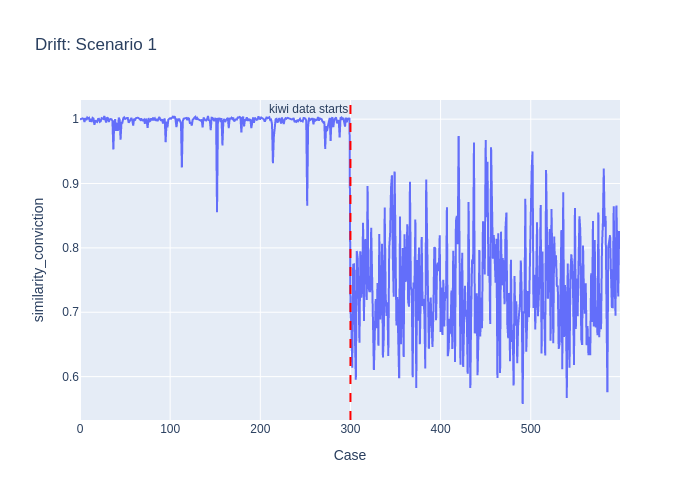

In [10]:
metric = "similarity_conviction"
graph_data = scenario_1_details[metric]

fig = px.line(graph_data, title='Drift: Scenario 1')
fig.add_vline(x=len(df_test_non_kiwi), line=dict(color='red', width=2, dash='dash'),
              annotation_text = "kiwi data starts",annotation_position="top left")
fig.update_layout(xaxis_title="Case", yaxis_title=f"{metric}", showlegend=False)

fig.show()

We can clearly see that the similarity conviction drops as soon as the kiwi data is introduced. If we see this live, this would be a strong indication that the incoming test data is not well represented by our training data and that we may need to reevalulate the model.

### Production test confirmation

To confirm this drift, we can see that our production model predicts none of the kiwi cases right.

In [11]:
scenario_1_predictions = scenario_1_production_model.predict(scenario_1_df_test[context_features].values)

# Only get the accuracy on kiwi data
accuracy = accuracy_score(scenario_1_df_test[action_features[0]].iloc[len(df_test_non_kiwi):], scenario_1_predictions[len(df_test_non_kiwi):])

print(f"Accuracy on Kiwi cases: {accuracy:.0%}")

Accuracy on Kiwi cases: 0%


### 1b. Debug

Howso is the only tool that allows you to both detect and debug drift. Howso's unique underlying platform works specifically on the data, which provides insights, flexibility, and control that other tools cannot.

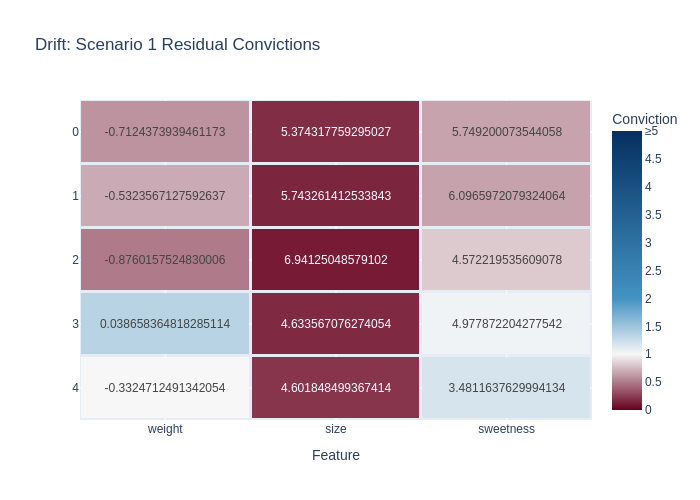

In [12]:
# Extract the global case feature residual convictions
case_feature_residual_convictions_full = pd.DataFrame(
    scenario_1_details['case_feature_residual_convictions_full']
)

plot_anomalies(
    scenario_1_df_test[context_features].loc[len(df_test_non_kiwi):].reset_index(drop=True),
    case_feature_residual_convictions_full[context_features].loc[len(df_test_non_kiwi):].reset_index(drop=True),
    title = 'Drift: Scenario 1 Residual Convictions'
)

## Results

**NOTE**: The values in this chart are the actual feature values. The color scale represents the conviction value.

As we can see, `size` generally has the lowest conviction among all of the features. This indicates that `size` is suprising for the incoming dataset. This matches exactly what we actually see in the test data, as we had purposely adjusted the `kiwi` data to have `size` values that are not in line with the other fruits.

This information allows us to not only monitor, but also debug the incoming data.

# Scenario 2: Data drift on a real dataset

In scenario 1, we used a dummy dataset to highlight, simply, and control exactly the type of data drift for demonstrative purposes. We will perform the exact same analysis in scenario 2, instead on a real data to show how it translates over.

## Data Prep

We will be using the `adult` dataset in scenario 2.

In [13]:
adult_df = fetch_data('adult', local_cache_dir='../../data/pmlb/adult')

# Subsample the data to ensure the example runs quickly
adult_df = adult_df.sample(2000)

scenario_2_df_train, scenario_2_df_test = train_test_split(adult_df, test_size=0.5, random_state=42)

For this scenario, we will focus on two features `age` and `education`. The descriptive statistics of these two features are shown:

In [14]:
scenario_2_df_train[['age', 'education']].describe()

,age,education
count,1000.000000,1000.000000
mean,38.779000,10.398000
std,13.609091,3.804217
min,17.000000,0.000000
25%,28.000000,9.000000
50%,38.000000,11.000000
75%,48.000000,12.000000
max,90.000000,15.000000


## Drift Scenario

To create data drift, we modify our new incoming test data to simulate the data coming from a different population. We do this by subtracting `10` from every `age`, and `5` from every `education`.

This simulates a younger and less educated population.

In [15]:
# We split the test data into two test datasets. `df_test_same_distribution` acts as a baseline test data, and `df_test_new_distribution` will be modified.
df_test_same_distribution, df_test_new_distribution = train_test_split(scenario_2_df_test, test_size=0.5, random_state=42)

In [16]:
# Subtract 10 from every value in the 'age' column
df_test_new_distribution['age'] -= 10

# Subtract 5 from every value in the 'education' column
df_test_new_distribution['education'] -= 5

# Observe new distributions
df_test_new_distribution[['age', 'education']].describe()

,age,education
count,500.000000,500.000000
mean,28.886000,5.442000
std,13.942374,3.736115
min,7.000000,-5.000000
25%,18.000000,4.000000
50%,27.000000,6.000000
75%,38.000000,7.000000
max,80.000000,10.000000


## 2a. Create, train, and analyze a Howso Trainee

In [17]:
# Infer the feature attributes on the training dataset
features = infer_feature_attributes(scenario_2_df_train)
action_features = ['target']
context_features = features.get_names(without=action_features)

t = Trainee(features=features)
t.train(scenario_2_df_train)
t.analyze()


### Get Howso Details

In [18]:
# Get details on the baseline test set from the same distribution/population
details = {
    'similarity_conviction': True,
    'case_feature_residual_convictions_full': True,
    }
scenario_2_same_distribution_details = t.react(
    df_test_same_distribution[context_features],
    details=details)['details']

# Get details on the modified test set from the younger distribution/population
details = {
    'similarity_conviction': True,
    'case_feature_residual_convictions_full': True,
    }
scenario_2_new_distribution_details = t.react(
    df_test_new_distribution[context_features],
    details=details)['details']

### Graph Results

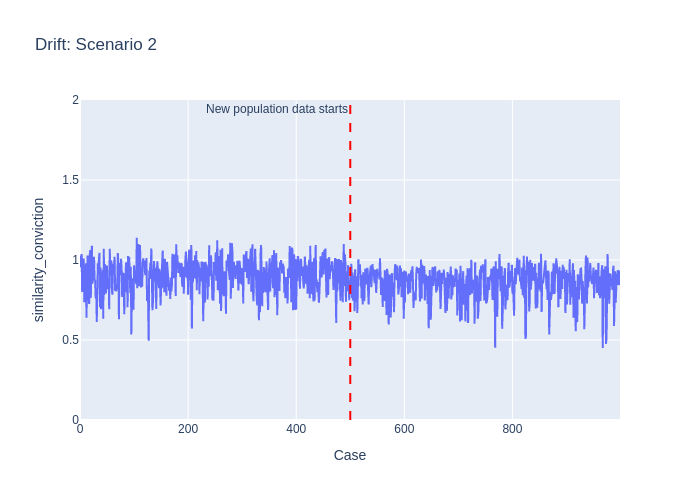

In [19]:
metric = "similarity_conviction"
graph_data = scenario_2_same_distribution_details[metric] + scenario_2_new_distribution_details[metric]

fig = px.line(graph_data, title='Drift: Scenario 2')
fig.add_vline(x=len(df_test_same_distribution), line=dict(color='red', width=2, dash='dash'),
              annotation_text = "New population data starts",annotation_position="top left")
fig.update_layout(xaxis_title="Case", yaxis_title=f"{metric}", yaxis=dict(range=[0, 2]), showlegend=False)

fig.show()

### Results

Just like in scenario 1, we can see a shift in the conviction once the new population data begins.

## 2b. Debug

In [20]:
# Extract the global case feature residual convictions
outlier_case_feature_residual_convictions = pd.DataFrame(
    scenario_2_new_distribution_details['case_feature_residual_convictions_full']
)

In this scenario, we take the average of the convictions of each column. This can be a useful view when working with a large test set.

In [21]:
avg_convictions = outlier_case_feature_residual_convictions[context_features].mean()

## Graph Results

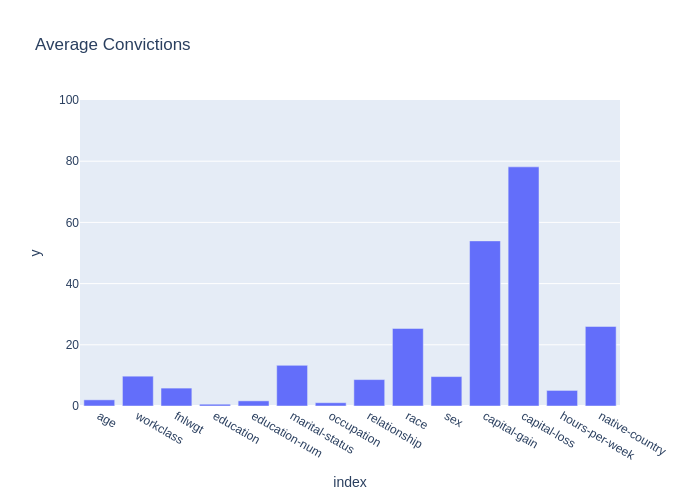

In [22]:
fig = px.bar(avg_convictions, x=avg_convictions.index, y=avg_convictions.values, title='Average Convictions')

# Put a limit on the y-axis
fig.update_layout(yaxis=dict(range=[0, 100]))

fig.show()

## Results

As we can see, features with the lowest conviction indicate features that are possible causes for the drift. We can see that `education` and `age` both show up as two of the lowest convictions. Complex relationships with other features may cause a few other features may also show up with low convictions, however this demonstrates that the features that are actually drifting are detected with this method.